<a href="https://colab.research.google.com/github/higordevellard/Machine_Learning_Electrical_Fault/blob/main/machine_learning_curto_circuito-------.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Predição de Curto-Circuito
# Sprint 02 - MVP parte 01






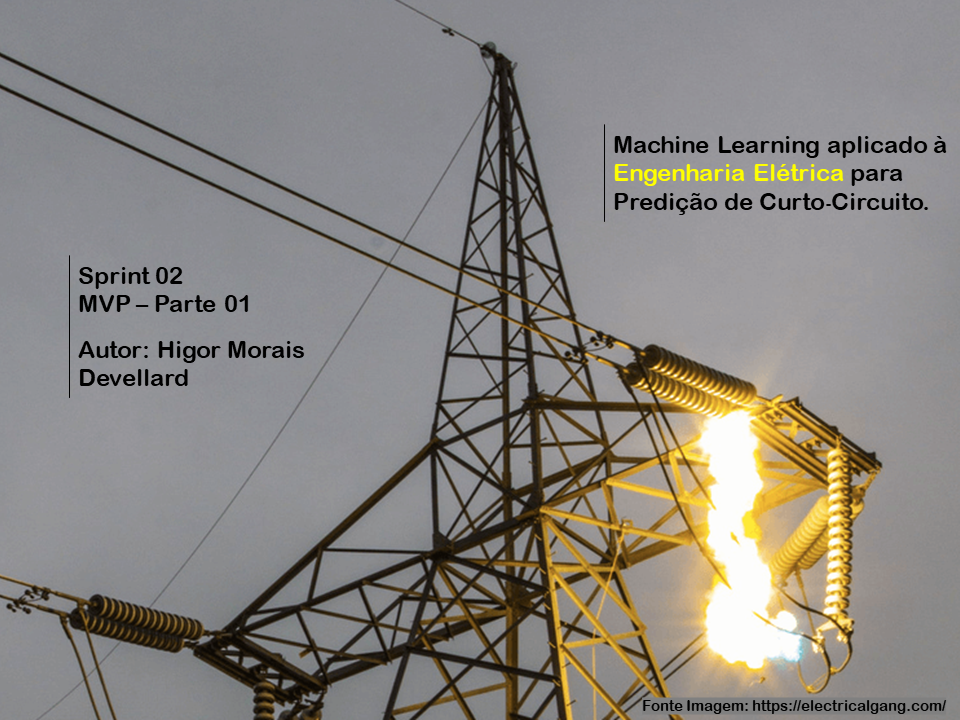

In [ ]:
import requests
from PIL import Image
from io import BytesIO

# Carregar a capa do projeto usando a biblioteca PIL
imagem_1 = 'https://raw.githubusercontent.com/higordevellard/Machine_Learning_Electrical_Fault/main/imagens/imagem_1.png'
request_imagem = requests.get(imagem_1)
imagem = Image.open(BytesIO(request_imagem.content))
imagem.show()


## 1.Motivação

*   Os curtos-circuitos são falhas que acontecem em diversos equipamentos elétricos como os transformadores, motores e geradores, resumindo os curtos-circuitos podem estar presentes em todos setores do sistema de energia, desde a geração, linhas de trasmissão e distribuição, até o consumidor final.
*   Dessa maneira, se faz necessário que quando a falha ocorra, equipamentos de proteção como os disjuntores e relés atuem instantâneamente para evitar danos permanentes aos equipamentos elétricos.
*   Este projeto visa analisar um dataset contendo valores de tensão e corrente de uma linha de transmissão e utilizando algoritmos de machine learning identifcar quando ocorre o curto-circuito e diferencia-lo entre os tipo de curtos-circuitos existentes.


## 2.Pacotes Usados

In [1]:
# Configuração para não exibir os warnings dos pacotes selecionados
import warnings
warnings.filterwarnings("ignore")

# Importação de pacotes
import requests
from PIL import Image
from io import BytesIO
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score

## 3.Carga do Dataset

O dataset escolhido para este projeto está disponível no Kaggle, conforme o seguinte endereço: https://www.kaggle.com/code/sahillyraina/electric-faults-detection-classification/input


In [ ]:
# Localicazão do dataset
url_1 = 'https://raw.githubusercontent.com/higordevellard/Machine_Learning_Electrical_Fault/main/classData.csv'

# Labels dos atributos do dataset
labels_atributos = ['Groung_fault', 'Cond_C_fault', 'Cond_B_fault', 'Cond_A_fault', 'Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

# Lê o arquivo
dataset = pd.read_csv(url_1, names=labels_atributos, header=0, delimiter=',')


### **3.1Informações sobre o dataset**

*   O dataset carregado contém registros de tensão (Em volts) e corrente (Em amperes) dos condutores pertencentes ao sistema de transmissão de energia elétrica dos EUA.

*   Os Atributos presentes no dataset, estão dividos em inputs e outputs, sendo:

**Inputs:**

'Ia', 'Ib' e 'Ic' = Valores de Corrente registrados em Amperes (A) nos condutores A, B e C.

'Va', 'Vb' e 'Vc' = Valores de Tensão registrados em Volts (V) nos condutores A, B e C.

**Outputs:**

'Cond_A_fault', 'Cond_B_fault', 'Cond_B_fault' e 'Ground_fault', atributos binários onde: '0' corresponde a ausência de curto circuito, e '1' presença de curto circuito, podendo estar presente no condutor A,B,C ou Ground (Terra) que é o condutor de proteção.




#### **3.1.1.Descrição dos tipos de Curto-Circuito**

Existem diversos tipos de curto-circuito, que podem acontecer devido à fatores externos e internos como o contato com objetos (galhos, passaros, balões, etc), Falha do isolamento dos condutores, descargas atmosféricas, erro humano e vibração dos cabos. Dessa maneira os curtos são classificados como simétricos e assimétricos, sendo:  

1.  Curto Circuito - Simétrico

  São faltas balanceadas e podem acontecer entre as três fases (A,B e C) ou (A,B,C e Ground). São mais difíceis de ocorrer, porém são as que apresentam poder destrutivo maior. Normalmente cerca de 5% dos curtos-circuitos são simétricos.

2.  Curto Circuito - Assimétrico

  São faltas desbalanceadas que podem ocorrer entre as fases, ou entre as fase e a Terra (Ground). Ex: Condutor A e Condutor B, Condutor B e Ground, condutor C e Ground e etc. Ocorrem com mais frequência no sistema elétrico.



## 4.Análise Exploratória de Dados

###4.1 Análise e Tratamento dos dados

In [ ]:
# Mostra as dimensões do dataset (linhas e colunas)
dataset.shape

(7861, 10)

In [ ]:
# Mostra as informações do dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Groung_fault  7861 non-null   int64  
 1   Cond_C_fault  7861 non-null   int64  
 2   Cond_B_fault  7861 non-null   int64  
 3   Cond_A_fault  7861 non-null   int64  
 4   Ia            7861 non-null   float64
 5   Ib            7861 non-null   float64
 6   Ic            7861 non-null   float64
 7   Va            7861 non-null   float64
 8   Vb            7861 non-null   float64
 9   Vc            7861 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 614.3 KB


**Observações importantes levantadas após os resultados da função .info():**

1)Todos os 10 atributos foram devidamente carregados.

2)Todas as 7861 Instâncias (linhas) são não nulas (Sem missings).



In [ ]:
# Verificar a presença de linhas duplicadas no dataset.
print(dataset.duplicated().sum())

0


In [ ]:
# Mostra as 5 primeiras linhas do dataset
dataset.head(5)

,Groung_fault,Cond_C_fault,Cond_B_fault,Cond_A_fault,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


Considerando que o output do dataset (Quatro primeiras colunas já estão em "hot-encoding", será mais conveniente concatenar as quatro primeiras colunas para que que sejá possível classificar em uma única coluna o tipo de curto-circuito.

In [ ]:
# Criando a nova coluna
dataset['Tipo_de_Curto_Circuito'] = dataset.iloc[:, 0:4].apply(lambda row: ''.join(str(x) for x in row), axis=1)

# Exibindo o dataset com a nova coluna
dataset.head(5)

,Groung_fault,Cond_C_fault,Cond_B_fault,Cond_A_fault,Ia,Ib,Ic,Va,Vb,Vc,Tipo_de_Curto_Circuito
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001


### **4.2.Estatísticas Descritivas**

Considerando que deve-se fazer o resumo estatístico apenas dos atributos quantitativos, serão removidas as demais colunas.

In [ ]:
# Resumo estatístico do dataset.
dataset.drop(['Groung_fault', 'Cond_C_fault', 'Cond_B_fault', 'Cond_A_fault', 'Tipo_de_Curto_Circuito'], axis=1).describe().round(2)

,Ia,Ib,Ic,Va,Vb,Vc
count,7861.00,7861.00,7861.00,7861.00,7861.00,7861.00
mean,13.72,-44.85,34.39,-0.01,0.00,0.01
std,464.74,439.27,371.11,0.29,0.31,0.31
min,-883.54,-900.53,-883.36,-0.62,-0.61,-0.61
25%,-119.80,-271.85,-61.03,-0.13,-0.16,-0.22
50%,2.04,5.51,-4.33,-0.01,0.00,0.01
75%,227.25,91.19,49.12,0.11,0.15,0.24
max,885.74,889.87,901.27,0.60,0.63,0.60


Considerando os 7861 registros analisados, é apresentado os valores de (média, desvio padrão, mínimo, máximo e os quartis dos valores de corrente e tensão dos condutores).
É importante observar que o valor da média e desvio padrão das corretens "Ia", "Ib" e "Ic" são considerados muito altos justamente por que em caso de curto-circuito o valor da corrente assume valores extremos, diferente da tensão que não se altera tanto.

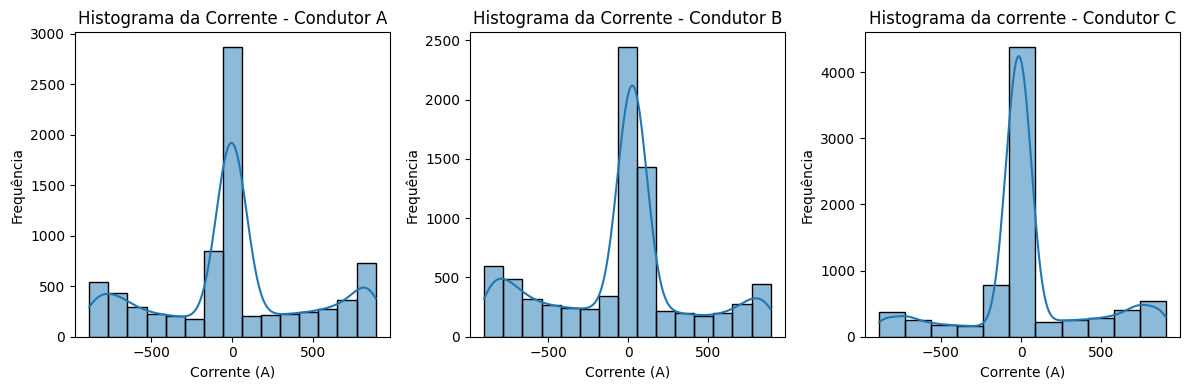

In [ ]:
# Criar um subplot com uma linha e três colunas
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Plotar o histograma de pontuação de crédito
sns.histplot(dataset['Ia'], kde=True, bins=15, ax=axs[0])
axs[0].set_xlabel("Corrente (A)")
axs[0].set_ylabel("Frequência")
axs[0].set_title("Histograma da Corrente - Condutor A")

# Plotar o histograma de Idade
sns.histplot(dataset['Ib'], kde=True, bins=15, ax=axs[1])
axs[1].set_xlabel("Corrente (A)")
axs[1].set_ylabel("Frequência")
axs[1].set_title("Histograma da Corrente - Condutor B")

# Plotar o histograma de tempo de conta do correntista
sns.histplot(dataset['Ic'], kde=True, bins=11, ax=axs[2])
axs[2].set_xlabel("Corrente (A)")
axs[2].set_ylabel("Frequência")
axs[2].set_title("Histograma da Corrente - Condutor C")

# Ajuste de layout
plt.tight_layout()

# Exibição dos histogramas
plt.show()

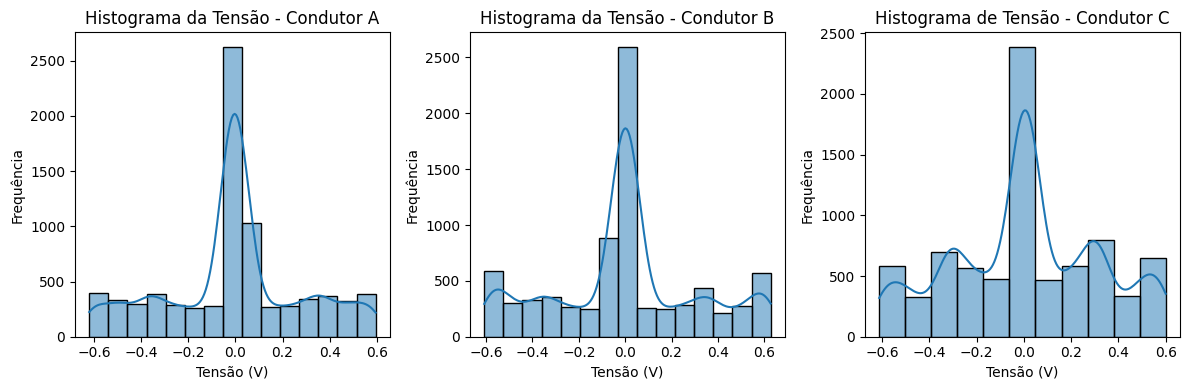

In [ ]:
# Criar um subplot com uma linha e três colunas
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Plotar o histograma de pontuação de crédito
sns.histplot(dataset['Va'], kde=True, bins=15, ax=axs[0])
axs[0].set_xlabel("Tensão (V)")
axs[0].set_ylabel("Frequência")
axs[0].set_title("Histograma da Tensão - Condutor A")

# Plotar o histograma de Idade
sns.histplot(dataset['Vb'], kde=True, bins=15, ax=axs[1])
axs[1].set_xlabel("Tensão (V)")
axs[1].set_ylabel("Frequência")
axs[1].set_title("Histograma da Tensão - Condutor B")

# Plotar o histograma de tempo de conta do correntista
sns.histplot(dataset['Vc'], kde=True, bins=11, ax=axs[2])
axs[2].set_xlabel("Tensão (V)")
axs[2].set_ylabel("Frequência")
axs[2].set_title("Histograma de Tensão - Condutor C")

# Ajuste de layout
plt.tight_layout()

# Exibição dos histogramas
plt.show()

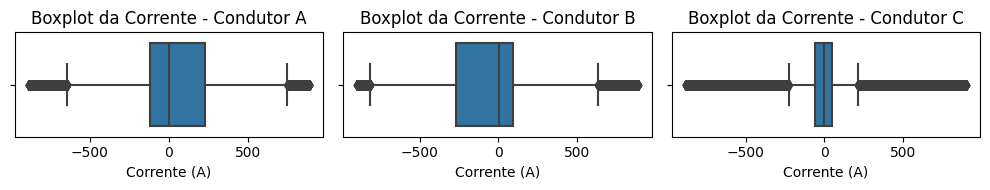

In [ ]:
# Criar um subplot com uma linha e três colunas
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))

# Plotar o boxplot de pontuação de crédito
sns.boxplot(x="Ia", data=dataset, ax=axs[0])
axs[0].set_title("Boxplot da Corrente - Condutor A")
axs[0].set_xlabel("Corrente (A)")

# Plotar o boxplot de Idade
sns.boxplot(x="Ib", data=dataset, ax=axs[1])
axs[1].set_title("Boxplot da Corrente - Condutor B")
axs[1].set_xlabel("Corrente (A)")

# Plotar o boxplot do tempo de correntista
sns.boxplot(x="Ic", data=dataset, ax=axs[2])
axs[2].set_title("Boxplot da Corrente - Condutor C")
axs[2].set_xlabel("Corrente (A)")

# Ajuste de layout
plt.tight_layout()

# Exibição dos boxplots
plt.show()


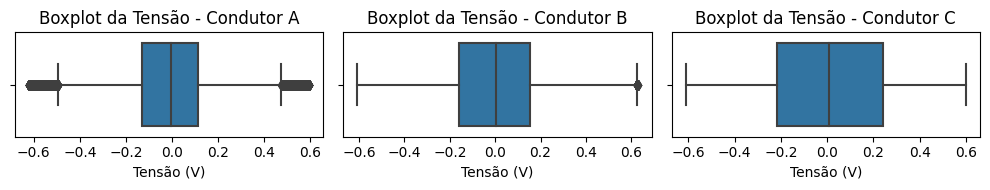

In [ ]:
# Criar um subplot com uma linha e três colunas
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))

# Plotar o boxplot de pontuação de crédito
sns.boxplot(x="Va", data=dataset, ax=axs[0])
axs[0].set_title("Boxplot da Tensão - Condutor A")
axs[0].set_xlabel("Tensão (V)")

# Plotar o boxplot de Idade
sns.boxplot(x="Vb", data=dataset, ax=axs[1])
axs[1].set_title("Boxplot da Tensão - Condutor B")
axs[1].set_xlabel("Tensão (V)")

# Plotar o boxplot do tempo de correntista
sns.boxplot(x="Vc", data=dataset, ax=axs[2])
axs[2].set_title("Boxplot da Tensão - Condutor C")
axs[2].set_xlabel("Tensão (V)")

# Ajuste de layout
plt.tight_layout()

# Exibição dos boxplots
plt.show()

O Boxplot apresentado indica outliers apenas para a pontuação de crédito e idade, porém não são de fato outliers, portanto não serão removidos.





**Correlação Heatmap**

<Axes: >

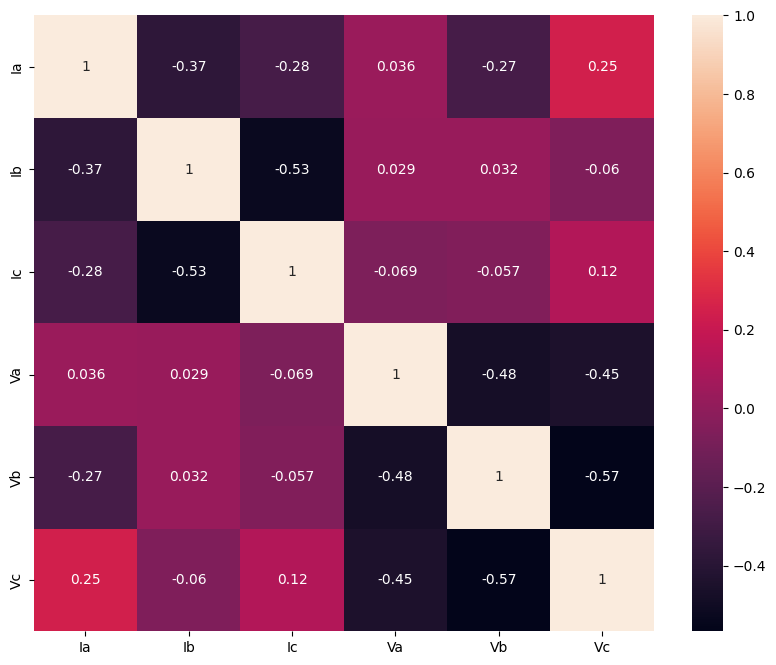

In [ ]:
#Achar a correlação entre os atributos
dataset_2 = dataset.drop(['Groung_fault', 'Cond_C_fault', 'Cond_B_fault', 'Cond_A_fault', 'Tipo_de_Curto_Circuito'], axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(dataset_2.corr(), fmt='.2g', annot=True)

# **5.Modelagem e Inferência**

## Separação em conjunto de treino e conjunto de teste com holdout

In [ ]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,4:10]
y = array[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Importância de Atributos com ExtraTrees

# Criação do modelo para seleção de atributos
modelo = ExtraTreesClassifier(n_estimators=100)
modelo.fit(X,y)

# Exibe os atributos orginais
print("\nAtributos Originais:", dataset.columns[0:14])

# Exibe a pontuação de importância para cada atributo (quanto maior a pontuação, mais importante é o atributo).
print(modelo.feature_importances_)

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação


Atributos Originais: Index(['Groung_fault', 'Cond_C_fault', 'Cond_B_fault', 'Cond_A_fault', 'Ia',
       'Ib', 'Ic', 'Va', 'Vb', 'Vc', 'Tipo_de_Curto_Circuito'],
      dtype='object')
[0.18286979 0.17474763 0.20283418 0.1501869  0.14260762 0.14675388]


In [ ]:
print("Dados de treino:")
print(X_train)  # Exibir primeiras linhas dos atributos de treino
print(y_train)  # Exibir primeiras linhas dos rótulos de treino

Dados de treino:
[[-58.76606348 -50.80814515 111.9082284 -0.492879312 -0.041879177
  0.534758489]
 [441.7059785 -14.77604334 44.01006859 0.297165503 -0.596759949
  0.299594446]
 [39.21879516 745.7430072 -782.9198497 0.038320297 -0.00355336
  -0.034766938]
 ...
 [-532.7703066 0.762722099 -39.59120622 -0.245047501 0.566525887
  -0.321478386]
 [-391.5465155 -65.97548358 43.8719659 0.364772168 -0.415344651
  0.050572483]
 [-71.60286103 61.73860535 6.759810797 -0.11492185 -0.447094794
  0.562016645]]
['0110' '1001' '0111' ... '1001' '1001' '0000']


Criação e avaliação de modelos: linha base

LR: 0.347646 (0.006524)
KNN: 0.815836 (0.010635)
CART: 0.878338 (0.014167)
NB: 0.796602 (0.010755)
SVM: 0.751110 (0.011927)
Bagging: 0.874522 (0.011402)
RF: 0.873408 (0.012701)
ET: 0.873250 (0.012400)
Ada: 0.632482 (0.048490)
GB: 0.848283 (0.010971)
Voting: 0.719782 (0.013127)


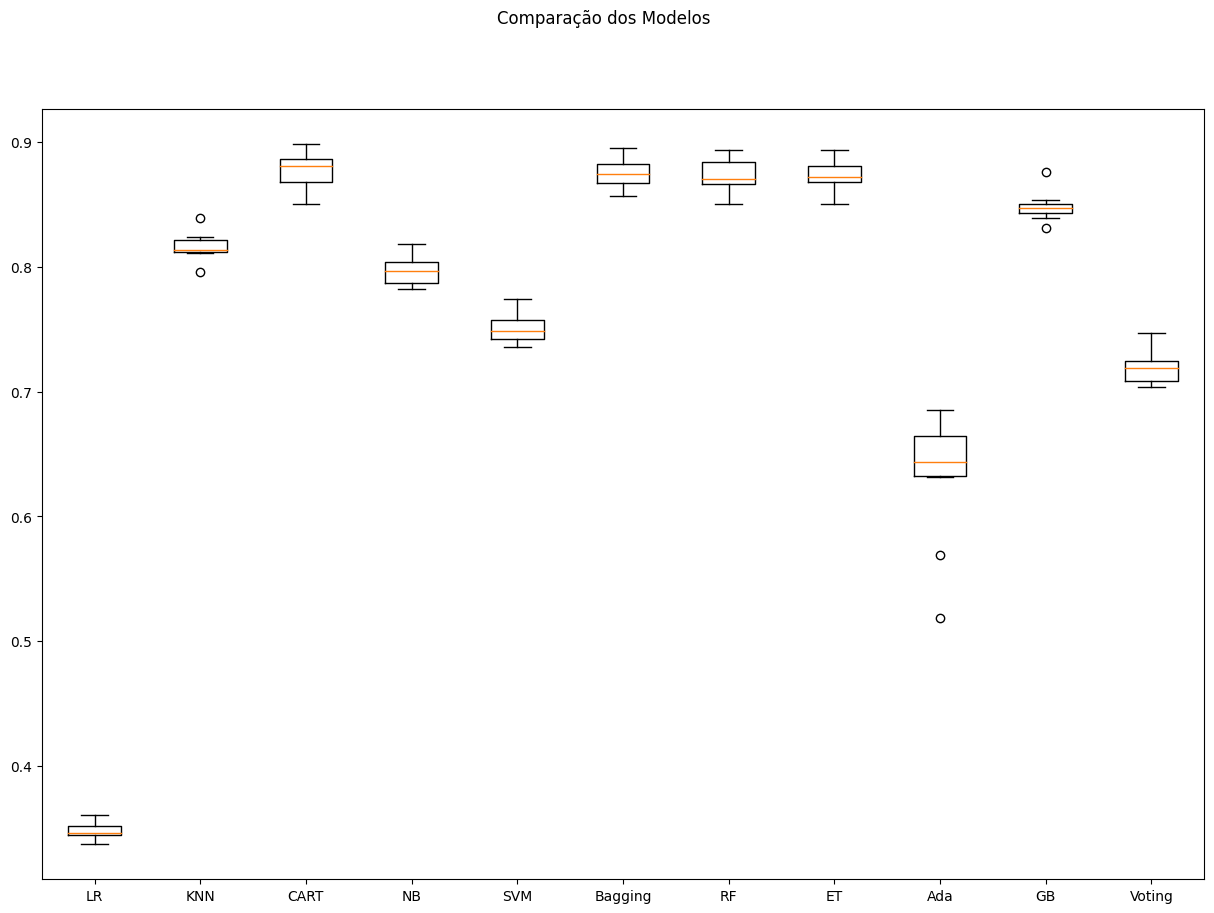

In [ ]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### **5.3.Criação e avaliação de modelos: dados padronizados e normalizados**

Considerando que alguns modelos podem apresentar melhores resultados quando os dados estão padronizados ou normalizados, então será realizada a comparação para avaliar se algum algoritmo irá superar a acurácia alcançada até o momento.

LR-orig: 0.348 (0.007)
KNN-orig: 0.816 (0.011)
CART-orig: 0.878 (0.014)
NB-orig: 0.797 (0.011)
SVM-orig: 0.751 (0.012)
Bag-orig: 0.875 (0.011)
RF-orig: 0.873 (0.013)
ET-orig: 0.873 (0.012)
Ada-orig: 0.632 (0.048)
GB-orig: 0.848 (0.011)
Vot-orig: 0.720 (0.013)
LR-padr: 0.346 (0.006)
KNN-padr: 0.816 (0.010)
CART-padr: 0.877 (0.013)
NB-padr: 0.795 (0.010)
SVM-padr: 0.810 (0.009)
Bag-padr: 0.875 (0.012)
RF-padr: 0.873 (0.012)
ET-padr: 0.876 (0.012)
Ada-padr: 0.632 (0.048)
GB-padr: 0.849 (0.011)
Vot-padr: 0.767 (0.013)
LR-norm: 0.338 (0.008)
KNN-norm: 0.829 (0.012)
CART-norm: 0.876 (0.013)
NB-norm: 0.795 (0.010)
SVM-norm: 0.812 (0.008)
Bag-norm: 0.873 (0.013)
RF-norm: 0.873 (0.010)
ET-norm: 0.875 (0.013)
Ada-norm: 0.632 (0.048)
GB-norm: 0.850 (0.011)
Vot-norm: 0.767 (0.010)


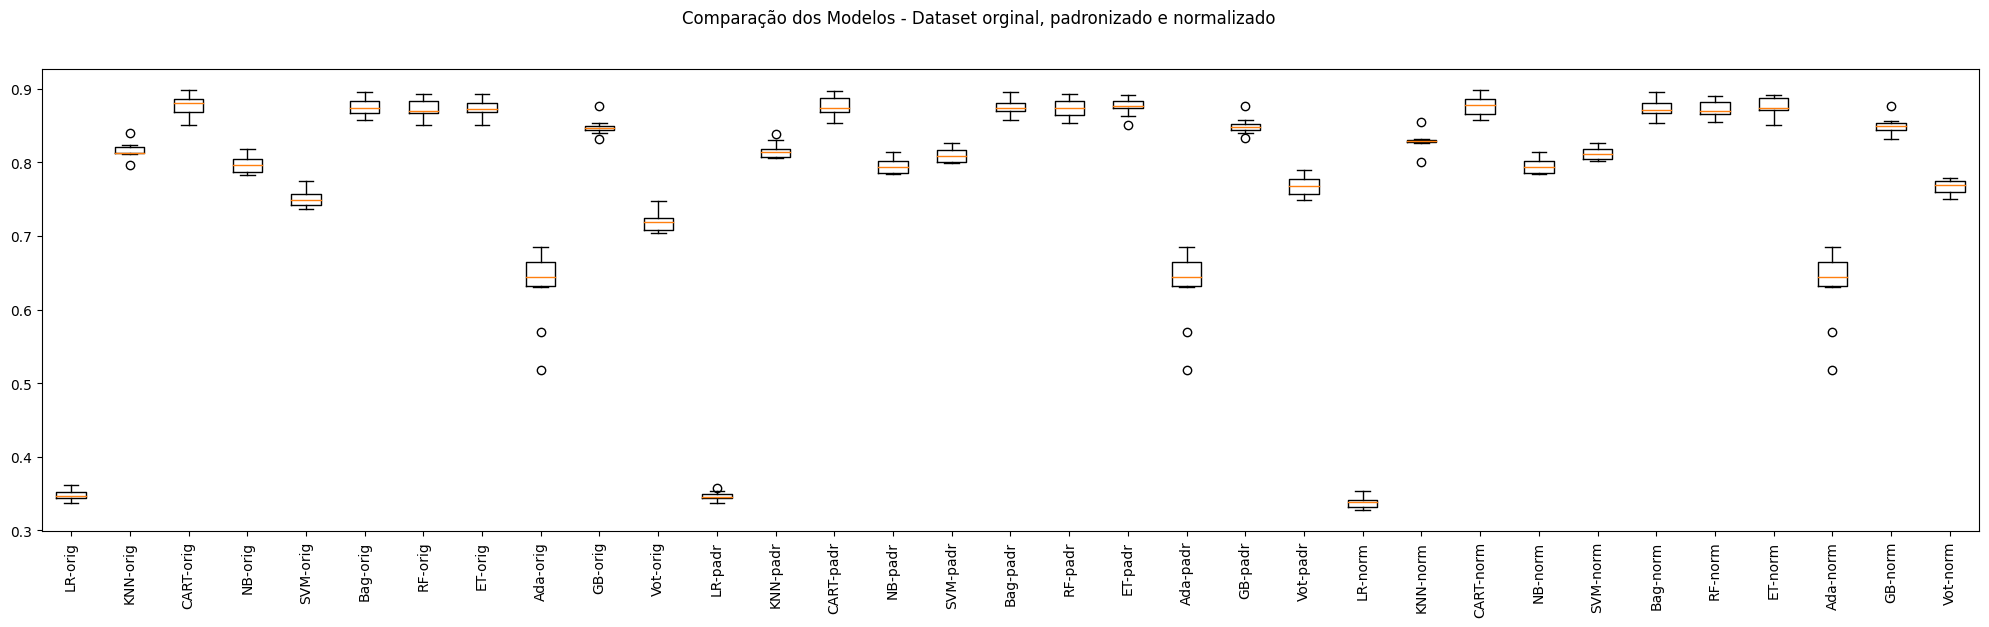

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

In [ ]:
# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = LogisticRegression(max_iter=200)
model.fit(rescaledX, y_train)

# Estimativa da probabilidade predita
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
y_scores = model.predict_proba(rescaledTestX)[:, 1]

# Cálculo da curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotagem da curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Avaliação da acurácia
predictions = model.predict(rescaledTestX)
accuracy = accuracy_score(y_test, predictions)
print('Acurácia:', accuracy)

ValueError: ignored

## **6.Simulando a aplicação do modelo em dados não vistos**

In [ ]:
# Novos dados - não sabemos a classe!
data = {'Ia':  [567, 720, 630],
        'Ib': [0, 1, 2],
        'Ic': [1, 1, 0],
        'Va': [30, 37, 60],
        'Vb': [5, 4, 2],
        'Vc': [52000, 57470, 67460],
        }

atributos = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:, np.r_[4:10]].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

IndexError: ignored

In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[1. 1. 1.]
